In [4]:
import os
import math
import torch
import torch.nn as nn
import torch.autograd as ag
import torchvision
import numpy as np

import ASDC_loader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        self.if_class = True
        self.ranges = ranges
        
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        
        #Initilize the paremeters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
                
    def forward(self, x):
        if self.if_class:
            x = self.features(x)
            x = x.view(x.size(0), 256 * 7 * 7)
            output = self.classifier(x)
            
        else: 
            output = {}
            # get the output of each maxpooling layer (5 maxpool in VGG net)
            for idx in range(len(self.ranges)):
                for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                    x = self.features[layer](x)
                output["x%d"%(idx+1)] = x
            
        return output
             
    
    def remove_classifier(self):
        del self.classifier
        self.if_class = False

ranges = ((0, 3), (3, 6), (6, 8), (8, 10), (10, 13))

In [6]:
class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 384, kernel_size=3, stride=1, padding=1, dilation=1, output_padding=0)
        self.bn2     = nn.BatchNorm2d(384)
        self.deconv3 = nn.ConvTranspose2d(384, 256, kernel_size=2, stride=5, padding=5, dilation=1, output_padding=2)
        self.bn3     = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
#                 print("Cov inilitized")
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
#                 print("BN inilitized")
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        self.pretrained_net = pretrained_net

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 256, 7, 7)
        x4 = output['x4']  # size=(N, 256, 15, 15)
        x3 = output['x3']  # size=(N, 384, 15, 15)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score  # size=(N, n_class, x.H/1, x.W/1)

# Training and deleting
### The following is for training the AlexNet and remove is fc layers. The weight will be saved on the file and lodaded, then the linear classifier(fc) will be removed.

In [7]:
model = AlexNet(2).to(device)

# Training

In [8]:
# Dataset
train_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='train', truncate=-1, crop=(256,256))

N = len(train_dataset) # Training set size 
B = 30 # Minibacth size
NB = int(N/B) # Number of minibatches
T = 10 # Number of epochs
gamma = 1e-4 # learning rate
rho = .09 # momentum
loss_set = []

# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                          num_workers=10)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho)

In [9]:
print("Training...")
print("Batchsize: ", B)
print("Num_epohs: ", T)
print("Learn_rate: ", gamma)
print("============================")
# print("Break point: epoch: {}, idx: {}".format(epoch, idx))

for epoch in range(T):
    running_loss = 0.0
    for idx, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        outputs = outputs.float()
        
        
        # Loss
        loss = criterion(outputs, labels)
        
        # Saving the loss
        loss_set.append(loss.detach().cpu())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print averaged loss per minibatch every 30 mini-batches
        running_loss += loss.item() 
        if idx % 100 == 99:
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, idx + 1, running_loss/100))
            running_loss = 0.0 
            
        
        # Saving the model
        if (idx+1) % 200 == 0:
            print("=====Model is saved at epoch: {}, idx: {}======".format(epoch+1, idx+1))
            torch.save(model.state_dict(), 'alexparams.pth')
            np.savetxt('alexloss.txt',loss_set,fmt='%0.8f')
        
        # Release RAM
        torch.cuda.empty_cache()

print('Finished Training')

Training...
Batchsize:  30
Num_epohs:  10
Learn_rate:  0.0001


Process Process-5:
Process Process-4:
Process Process-7:
Process Process-2:
Process Process-6:
Process Process-8:
Process Process-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-9:
Traceback (most recent call last):
Process Process-3:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
 

  File "/datasets/home/34/234/yas109/.local/lib/python3.6/site-packages/imageio/core/functions.py", line 221, in imread
    reader = read(uri, format, "i", **kwargs)
  File "/datasets/home/34/234/yas109/ece285f/alexnet/ASDC_loader.py", line 136, in __getitem__
    image = self.get_image(imageID)
  File "/datasets/home/34/234/yas109/ece285f/alexnet/ASDC_loader.py", line 66, in get_image
    image = imageio.imread(full_filename)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/datasets/home/34/234/yas109/.local/lib/python3.6/site-packages/imageio/core/functions.py", line 143, in get_reader
    return format.get_reader(request)
  File "/datasets/home/34/234/yas109/.local/lib/python3.6/site-packages/imageio/core/functions.py", line 143, in get_reader
    return format.get_reader(request)
  File "/datasets/home/34/234/yas109/ece285f/alexnet/ASDC_loader.py", line 66,

KeyboardInterrupt: 

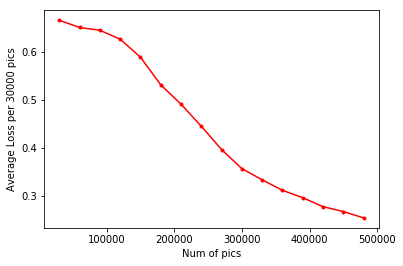

In [6]:
import matplotlib.pyplot as plt
import numpy as np

loss_set = np.loadtxt('loss.txt',dtype=np.float64)
B =30
n = 1000   # number of numbers for the average
start = 0  # plot start point
train_times = len(loss_set) # end of the loss_set, plot end point 

loss_over_n_episodes = []
x = []

for i in range(start,int(train_times/n)):
    loss_over_n_episodes.append(sum(loss_set[n*i:n*(i+1)-1])/n)
    x.append((i+1)*n*B)
plt.plot(x,loss_over_n_episodes,'.-r')
plt.ylabel('Average Loss per {} pics'.format(B*n))
plt.xlabel('Num of pics')
plt.show()

In [ ]:
# Save the model manually
torch.save(model.state_dict(), 'alexparams.pth')
print("=====Model is saved ======")
model

### Test the out put size of the AlexNet feature extracter

In [ ]:
for idx, (images, is_ships) in enumerate(train_loader):
    if idx > 3:
        break
images = images.to(device)
outputs = model(images)

In [ ]:
outputs["x5"].shape

In [ ]:
outputs["x4"].shape

In [ ]:
outputs["x3"].shape

### Building a new fcn model with the trained AlexNet 

In [ ]:
alex_model = AlexNet(2)
alex_model.load_state_dict(torch.load('alexparams.pth'))
alex_model.remove_classifier()
fcn_model = FCN8s(pretrained_net=alex_model, n_class=2).to(device)

### Testing the shape of the output, wether it will give us the 2 channel mask with size 256*256

In [ ]:
images = images.to(device)
outputs = fcn_model(images)

In [ ]:
outputs.shape

# Training for our tasks!

In [ ]:
# Data set
train_dataset = ASDC_loader.ASDC_Crop_Mask2_Dataset(dataset='train', truncate=-1, crop=(256,256))

B = 30 # Minibacth size
T = 10 # Number of epochs
gamma = 1e-4 # learning rate
rho = .09 # momentum
loss_set = []


# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                          num_workers=10)


criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.SGD(fcn_model.parameters(), lr=gamma, momentum=rho)

In [ ]:
print("Batchsize: ", B)
print("Num_epohs: ", T)
print("Learn_rate: ", gamma)
print("============================")
# print("Break point: epoch: {}, idx: {}".format(epoch, idx))

for epoch in range(T):
    epoch
    running_loss = 0.0
    for idx, (images, labels) in enumerate(train_loader):
        
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = fcn_model(images)
        outputs = outputs.float()
        
        
        # Loss
        loss = criterion(outputs, labels)
        
        #saving the loss
        loss_set.append(loss.detach().cpu())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print averaged loss per minibatch every 30 mini-batches
        running_loss += loss.item() 
        if idx % 100 == 99:
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, idx + 1, running_loss/100))
            running_loss = 0.0 
            
        
        # Saving the model
        if (idx+1) % 200 == 0:
            print("=====Model is saved at epoch: {}, idx: {}======".format(epoch+1, idx+1))
            torch.save(fcn_model.state_dict(), 'params.pth')
            np.savetxt('loss.txt',loss_set,fmt='%0.8f')
        
#         if loss.detach().cpu() <= min(loss_set):
#             print("=====Best Model is saved at epoch: {}, idx: {}, loss: {}======".format(epoch+1, idx+1, loss.detach().cpu()))
#             torch.save(fcn_model.state_dict(), 'params_best.pth')
#             np.savetxt('loss_best.txt',loss_set,fmt='%0.8f')
        

        # Release RAM
        torch.cuda.empty_cache()

print('Finished Training')

### The model will saved it self so that we can deal with the break down of our sever. Loading the result befere using the following and then continuing trining it.

In [ ]:
# Save the model manually
print("=====Model is saved at epoch: {}, idx: {}======".format(epoch+1, idx+1))
torch.save(fcn_model.state_dict(), 'fcnparams.pth')
np.savetxt('fcnloss.txt',loss_set,fmt='%0.8f')

### Plot the loss curve of this traing process, always save model first!!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

loss_set = np.loadtxt('loss.txt',dtype=np.float64)

n = 2000   # number of numbers for the average
start = 0  # plot start point
train_times = len(loss_set) # end of the loss_set, plot end point 

loss_over_n_episodes = []
x = []

for i in range(start,int(train_times/n)):
    loss_over_n_episodes.append(sum(loss_set[n*i:n*(i+1)-1])/n)
    x.append((i+1)*n*B)
plt.plot(x,loss_over_n_episodes,'.-r')
plt.ylabel('Average Loss per {} pics'.format(B*n))
plt.xlabel('Num of pics')
plt.show()